In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('New_York_City_Airbnb_Open_Data.csv')

In [3]:
data.fillna(0, inplace=True)

In [4]:
col= ['neighbourhood_group',
    'room_type',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count',
    'availability_365']

X = data[col]
y = np.log1p(data.price)

In [20]:
data.shape, X.shape

((48895, 16), (48895, 9))

In [5]:
X.dtypes

neighbourhood_group                object
room_type                          object
latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [6]:
num_col = ['latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count',
    'availability_365']

cat_col = ['neighbourhood_group','room_type']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=1)

In [22]:
X_train.shape

(29337, 9)

In [33]:
X_train_dict = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dict)
dv_col = dv.get_feature_names()
X_train = pd.DataFrame(X_train, columns= dv_col)

X_val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(X_val_dict)
X_val = pd.DataFrame(X_val, columns=dv_col)

X_test_dict = X_test.to_dict(orient='records')
X_test = dv.transform(X_test_dict)
X_test = pd.DataFrame(X_test, columns=dv_col)

In [43]:
list(X_train.columns)

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

In [35]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [45]:
from sklearn.tree import export_text
print(export_text(dt,feature_names = dv_col))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



In [48]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)
rf_val_pred = rf.predict(X_val)


In [50]:
np.sqrt(mean_squared_error(rf_val_pred, y_val))

0.466902911117568

In [71]:
params = list(range(10,200,10))
scores = []
for i in params:
    rf = RandomForestRegressor(n_estimators=i,random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)
    rf_val_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(rf_val_pred, y_val))
    scores.append((i,rmse))

<AxesSubplot:xlabel='n_estimator'>

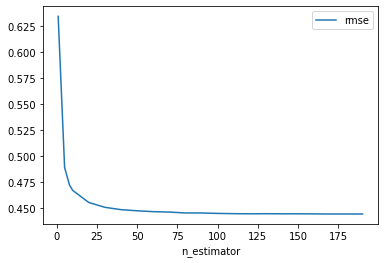

In [70]:
pd.DataFrame(scores,columns=['n_estimator', 'rmse']).plot(x='n_estimator', y='rmse' )


In [ ]:
pd.DataFrame(scores,columns=['n_estimator', 'rmse']).plot

In [79]:
max_depths = [10, 15, 20, 25]
scores2  = []
for j in max_depths:
    
    for i in params:
        rf = RandomForestRegressor(max_depth=j,n_estimators=i,random_state=1,n_jobs=-1)
        rf.fit(X_train,y_train)
        rf_val_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(rf_val_pred, y_val))
        scores2.append((j,i,rmse))

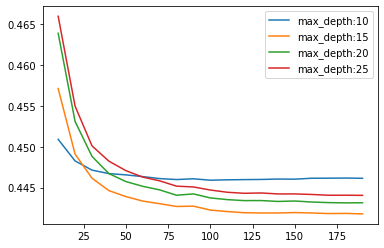

In [81]:
df_score2 = pd.DataFrame(scores2,columns= ['max_depth','n_estimator', 'rmse'])
for j in max_depths:
    df_subset = df_score2 [df_score2.max_depth==j]
    plt.plot(df_subset.n_estimator,df_subset.rmse, label = f'max_depth:{j}')
    
plt.legend()

In [84]:
rf2 = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf2.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [119]:
df_feature_importances= pd.DataFrame({'feature_names': dv.feature_names_,
                                      'feature_importances':rf2.feature_importances_})
df_feature_importances

,feature_names,feature_importances
0,availability_365,0.080650
1,calculated_host_listings_count,0.032574
2,latitude,0.146983
3,longitude,0.158823
4,minimum_nights,0.050588
5,neighbourhood_group=Bronx,0.000263
6,neighbourhood_group=Brooklyn,0.001051
7,neighbourhood_group=Manhattan,0.028138
8,neighbourhood_group=Queens,0.001384
9,neighbourhood_group=Staten Island,0.000080


In [124]:
df_feature_importances.loc[df_feature_importances['feature_importances'].idxmax()]

feature_names          room_type=Entire home/apt
feature_importances                     0.391285
Name: 12, dtype: object

In [130]:
!pip install  xgboost

In [132]:
import xgboost as xgb
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label= y_train, feature_names= features)
dval = xgb.DMatrix(X_val, label= y_val, feature_names= features)

In [133]:
watch_lst = [(dtrain, 'train'),(dval,'val')]

In [138]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [139]:
xgb.train(xgb_params, dtrain, evals = watch_lst, num_boost_round = 100  )

[0]	train-rmse:4.25190	val-rmse:4.25268
[1]	train-rmse:4.20996	val-rmse:4.21075
[2]	train-rmse:4.16845	val-rmse:4.16925
[3]	train-rmse:4.12736	val-rmse:4.12817
[4]	train-rmse:4.08667	val-rmse:4.08750
[5]	train-rmse:4.04640	val-rmse:4.04726
[6]	train-rmse:4.00654	val-rmse:4.00741
[7]	train-rmse:3.96708	val-rmse:3.96798
[8]	train-rmse:3.92803	val-rmse:3.92894
[9]	train-rmse:3.88937	val-rmse:3.89030
[10]	train-rmse:3.85109	val-rmse:3.85206
[11]	train-rmse:3.81321	val-rmse:3.81418
[12]	train-rmse:3.77571	val-rmse:3.77671
[13]	train-rmse:3.73860	val-rmse:3.73960
[14]	train-rmse:3.70185	val-rmse:3.70288
[15]	train-rmse:3.66548	val-rmse:3.66652
[16]	train-rmse:3.62948	val-rmse:3.63053
[17]	train-rmse:3.59385	val-rmse:3.59492
[18]	train-rmse:3.55857	val-rmse:3.55966
[19]	train-rmse:3.52366	val-rmse:3.52477
[20]	train-rmse:3.48910	val-rmse:3.49023
[21]	train-rmse:3.45488	val-rmse:3.45605
[22]	train-rmse:3.42102	val-rmse:3.42220
[23]	train-rmse:3.38750	val-rmse:3.38871
[24]	train-rmse:3.35432	va